# 네이버 검색어 트렌드

In [142]:
import requests
import json
from pandas import DataFrame, to_datetime
import sys
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import DataFrame, MultiIndex, concat, DatetimeIndex
from matplotlib import pyplot as plt
sys.path.append("../../helper")
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime as dict
from matplotlib import pyplot as pyplot
from matplotlib import dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from tabulate import tabulate

from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima
import seaborn as sb

#from helper import set_datetime_index, exp_time_data


https://developers.naver.com/docs/serviceapi/datalab/search/search.md#%ED%86%B5%ED%95%A9-%EA%B2%80%EC%83%89%EC%96%B4-%ED%8A%B8%EB%A0%8C%EB%93%9C

## 네이버 검색어 트렌드 OpenAPI 연동


### 접속에 필요한 정보 설정

####

In [143]:
#  API URL
API_URL = "https://openapi.naver.com/v1/datalab/search"

In [144]:
# 발급받은 인증키 
client_id = "qvJArzt0yr0YCZLEIpvk"
client_Secret = "dKxtYAT3QN"

In [145]:
# 접속객체 생성
session = requests.Session()
session.headers.update(
    {'X-Naver-Client-id': client_id,
      "X-Naver-Client-Secret" : client_Secret
      } 
)

### HTTP 접속 방법 종류

#### HTTP GET 방식인 경우
session.get(API_URL, params={"a": 100, "b": 200})

#### HTTP POST 방식인 경우
session.post(API_URL, data={"a": 100, "b": 200})

#### HTTP POST 방식이면서 파라미터를 JSON으로 구성하는 경우(body data 전송)
session.post(API_URL, data=json.dumps({"a": 100, "b": 200}))

전달할 검색어 구성

In [146]:
data = {
    "startDate": "2020-01-01",   # 2016년 1월 1일부터 조회 시작 가능
    "endDate": "2023-07-31",
    "timeUnit": "month",         # date: 일간, week: 주간, month: 월간
    "device" : "mo", # pc, PC에서 검색 추이 , mo 모바일에서 검색 추이
    "gender" : "f", # m는 남성, f는 여성  
    "keywordGroups": [
        # {
        #     "groupName": "코로나",  # 검색주제
        #     "keywords": ["코로나", "Covid19", "격리", "확진자"]   # 주제와 관련된 검색어
        # },
        {
            "groupName": "주우재",  # 검색주제
            "keywords": ["놀면뭐하니", "런닝맨",'주우재']   # 주제와 관련된 검색어
        }
    ]
}

데이터 요청하기

In [147]:
r = session.post(API_URL, data=json.dumps(data))

if r.status_code != 200:
    msg = "[%d Error] %s 에러가 발생함" % (r.status_code, r.reason)
    raise Exception(msg)

r.encoding = "utf-8"
mydict = json.loads(r.text)
mydict

{'startDate': '2020-01-01',
 'endDate': '2023-07-31',
 'timeUnit': 'month',
 'results': [{'title': '주우재',
   'keywords': ['놀면뭐하니', '런닝맨', '주우재'],
   'data': [{'period': '2020-01-01', 'ratio': 36.18665},
    {'period': '2020-02-01', 'ratio': 41.15528},
    {'period': '2020-03-01', 'ratio': 40.96566},
    {'period': '2020-04-01', 'ratio': 31.42839},
    {'period': '2020-05-01', 'ratio': 59.71074},
    {'period': '2020-06-01', 'ratio': 70.78666},
    {'period': '2020-07-01', 'ratio': 66.19082},
    {'period': '2020-08-01', 'ratio': 62.53519},
    {'period': '2020-09-01', 'ratio': 54.20595},
    {'period': '2020-10-01', 'ratio': 56.49327},
    {'period': '2020-11-01', 'ratio': 42.81003},
    {'period': '2020-12-01', 'ratio': 44.99017},
    {'period': '2021-01-01', 'ratio': 50.17703},
    {'period': '2021-02-01', 'ratio': 34.90846},
    {'period': '2021-03-01', 'ratio': 42.77671},
    {'period': '2021-04-01', 'ratio': 100},
    {'period': '2021-05-01', 'ratio': 95.3768},
    {'period': '202

가져온 결과를 데이터프레임으로 변환

In [148]:
df = DataFrame(mydict['results'][0]['data'])
df.head()

,period,ratio
0,2020-01-01,36.18665
1,2020-02-01,41.15528
2,2020-03-01,40.96566
3,2020-04-01,31.42839
4,2020-05-01,59.71074


In [149]:
# df = DataFrame(mydict['results'][1]['data'])
# df.head()

# 연동 결과에 대한 시계열 분석

데이터 타입 확인 

In [150]:
df.dtypes

period     object
ratio     float64
dtype: object

날짜 컬럼에 대한 형변환 및 인덱스 설정

In [158]:

def set_datetime_index(df, field=None, inplace=False): # 데이터 프레임의 인덱스를 datetime 형식으로 변환
   
    if inplace:
        if field is not None:
            df.set_index(field, inplace=True)
            
        df.index = DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
        df.sort_index(inplace=True)
    else:
        cdf = df.copy()
        
        if field is not None:
            cdf.set_index(field, inplace=True)
            
        cdf.index = DatetimeIndex(cdf.index.values, freq=cdf.index.inferred_freq)
        cdf.sort_index(inplace=True)
        return cdf
    
df['period'] = to_datetime(df['period'])
df2 = set_datetime_index(df,'period')
df2.head()

,ratio
2020-01-01,36.18665
2020-02-01,41.15528
2020-03-01,40.96566
2020-04-01,31.42839
2020-05-01,59.71074


In [152]:
    
def expTimeData(data, yname, sd_model="m", max_diff=1):
    plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
    plt.rcParams["font.size"] = 12
    plt.rcParams["axes.unicode_minus"] = False

    df = data.copy()

    # 데이터 정상성 여부
    stationarity = False

    # 반복 수행 횟수
    count = 0

    # 결측치 존재 여부
    na_count = df[yname].isna().sum()
    print("결측치 수: %d" % na_count)

    plt.figure(figsize=(4, 5))
    sb.boxplot(data=df, y=yname)
    plt.show()
    plt.close()
    
    # 시계열 분해
    model_name = 'multiplicative' if sd_model == 'm' else 'additive'
    sd = seasonal_decompose(df[yname], model=model_name)

    figure = sd.plot()
    figure.set_figwidth(15)
    figure.set_figheight(16)
    fig, ax1, ax2, ax3, ax4 = figure.get_children()
    figure.subplots_adjust(hspace=0.4)

    ax1.set_ylabel("Original")
    ax1.grid(True)
    ax1.title.set_text("Original")
    ax2.grid(True)
    ax2.title.set_text("Trend")
    ax3.grid(True)
    ax3.title.set_text("Seasonal")
    ax4.grid(True)
    ax4.title.set_text("Residual")

    plt.show()

    # ACF, PACF 검정
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    fig.subplots_adjust(hspace=0.4)

    sb.lineplot(data=df, x=df.index, y=yname, ax=ax1)
    ax1.title.set_text("Original")

    plot_acf(df[yname], ax=ax2)
    ax2.title.set_text("ACF Test")
        
    plot_pacf(df[yname], ax=ax3)
    ax3.title.set_text("PACF Test")
        
    plt.show()
    plt.close()

    while not stationarity:
        if count == 0:
            print("=========== 원본 데이터 ===========")
        else:
            print("=========== %d차 차분 데이터 ===========" % count)

        # ADF Test
        ar = adfuller(df[yname])

        ardict = {
            '검정통계량(ADF Statistic)': [ar[0]],
            '유의수준(p-value)': [ar[1]],
            '최적차수(num of lags)': [ar[2]],
            '관측치 개수(num of observations)': [ar[3]]   
        }

        for key, value in ar[4].items():
            ardict['기각값(Critical Values) %s' % key] = value

        stationarity = ar[1] < 0.05
        ardict['데이터 정상성 여부(0=Flase,1=True)'] = stationarity

        ardf = DataFrame(ardict, index=['ADF Test']).T

        print(tabulate(ardf, headers=["ADF Test", ""], tablefmt='psql', numalign="right"))

        # 차분 수행
        df = df.diff().dropna()

        # 반복을 계속할지 여부 판단
        count += 1
        if count == max_diff:
            break
def exp_time_data(data, yname, sd_model="m", max_diff=1):
    expTimeData(data, yname, sd_model, max_diff)

결측치 수: 0


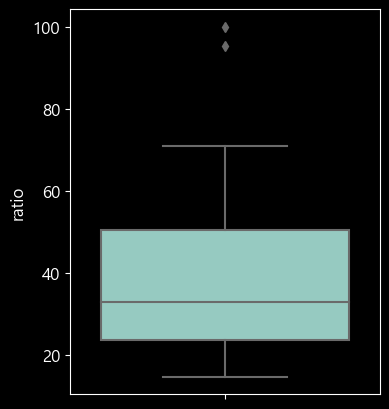

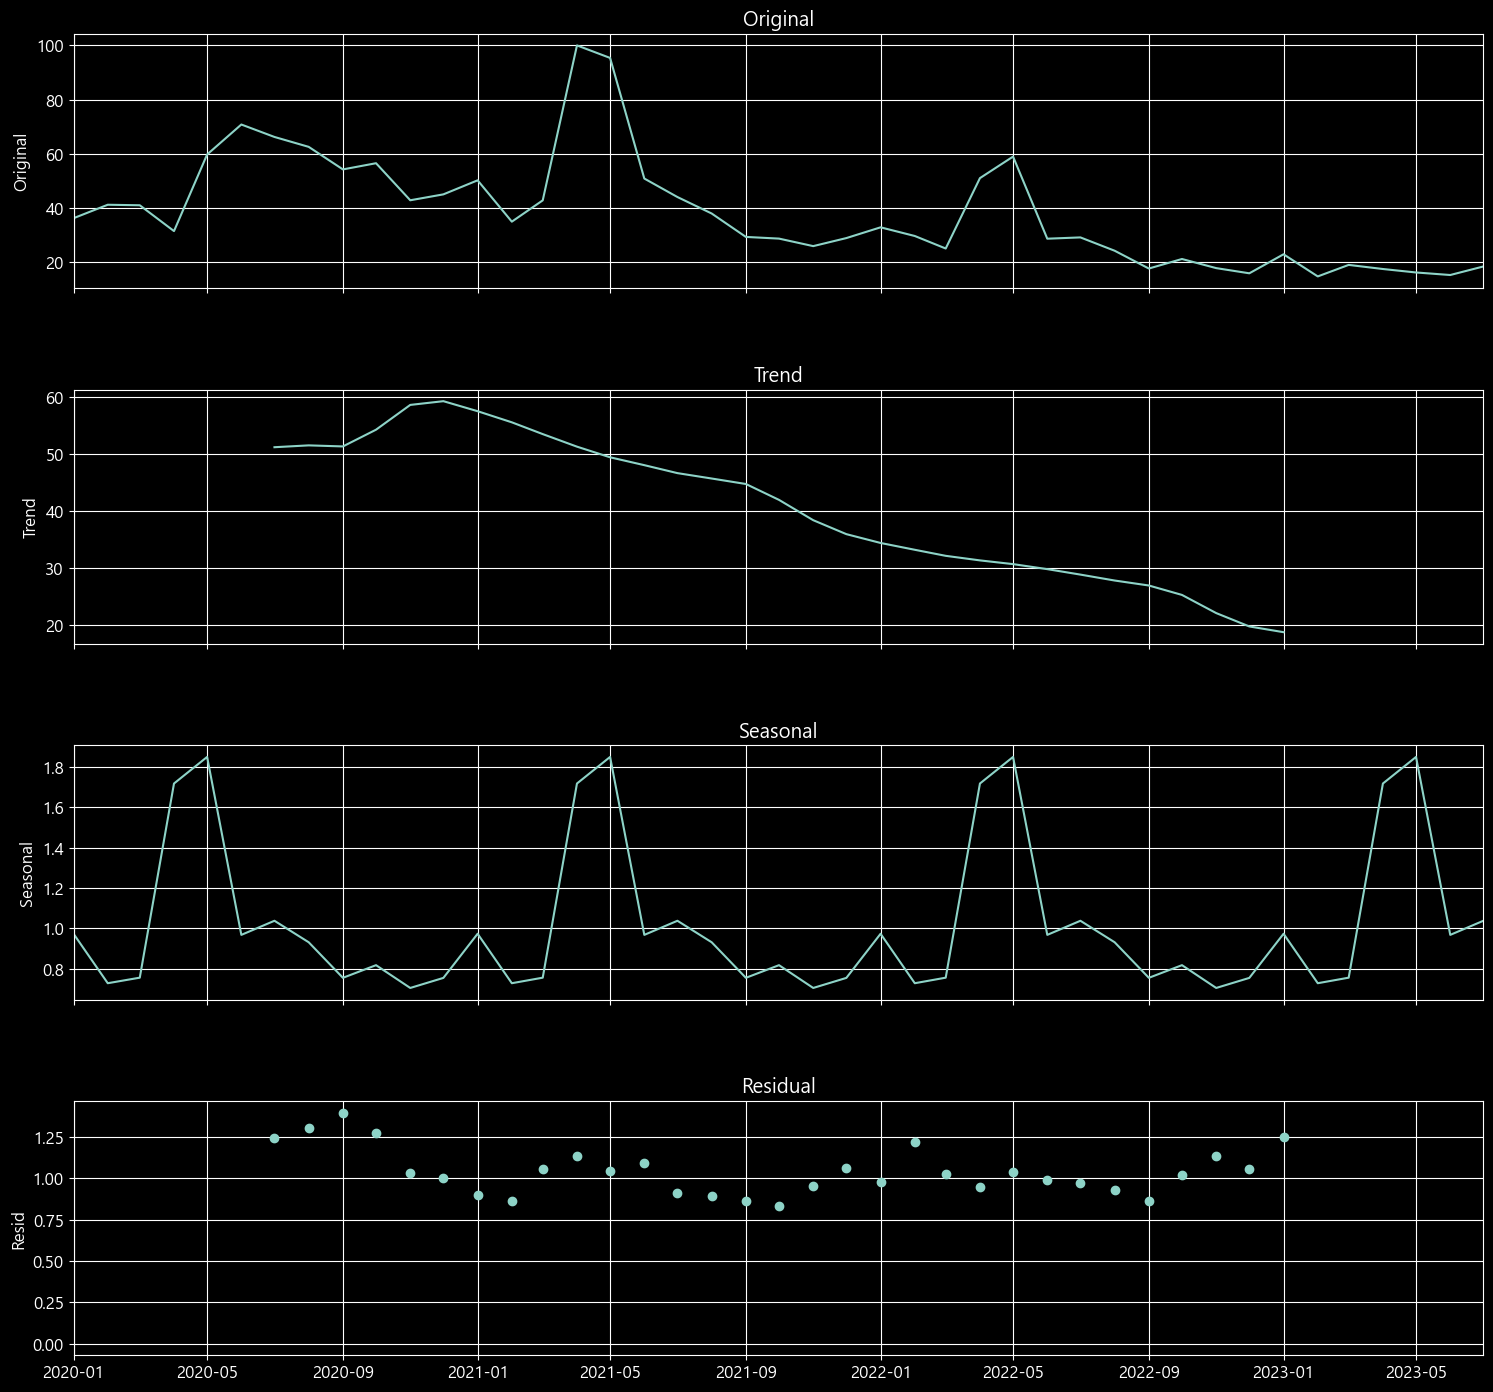

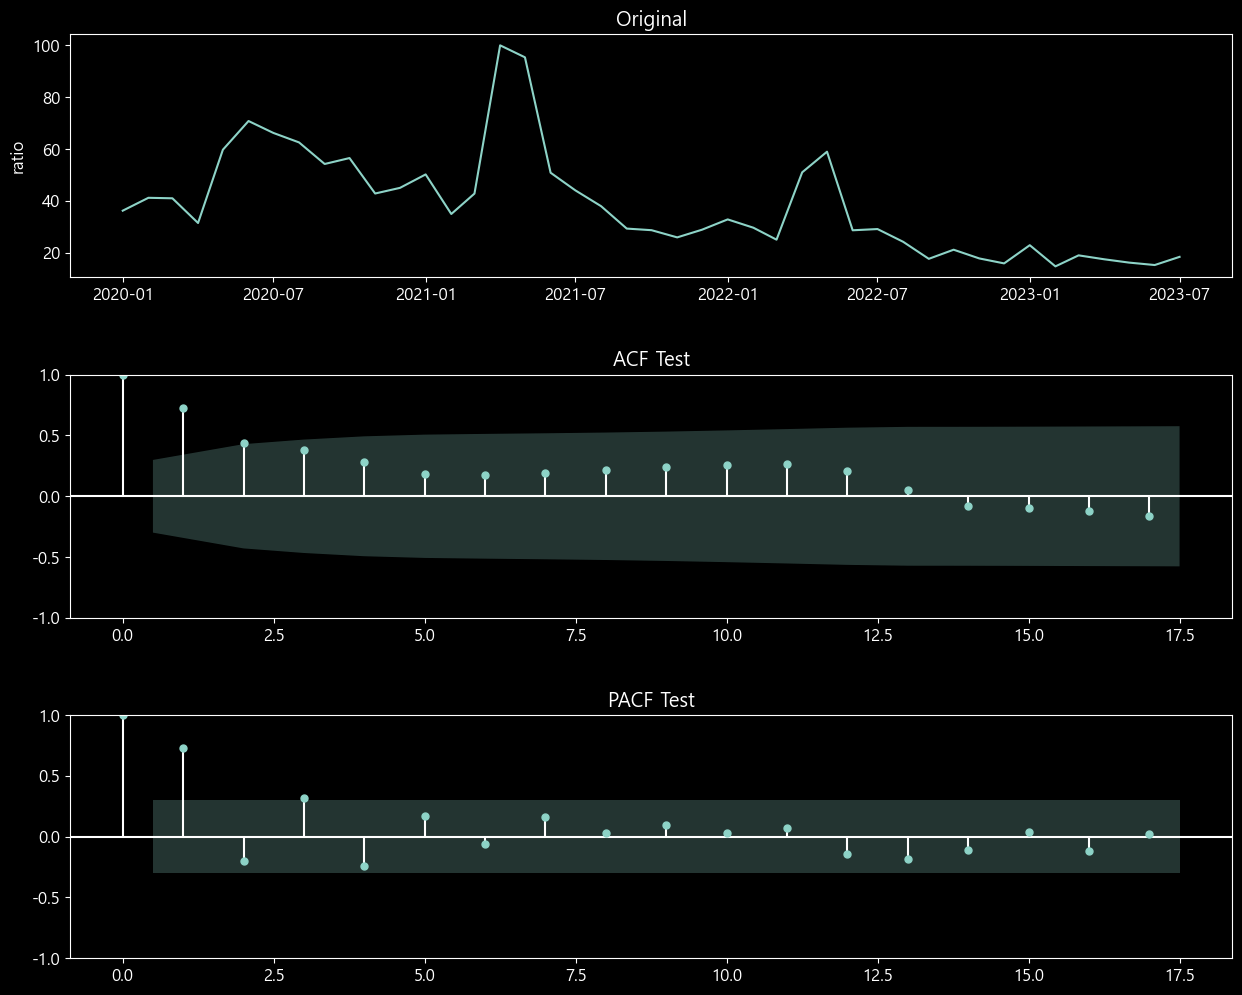

=========== 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -1.33629 |
| 유의수준(p-value)                  | 0.612409 |
| 최적차수(num of lags)              |        4 |
| 관측치 개수(num of observations)   |       38 |
| 기각값(Critical Values) 1%         | -3.61551 |
| 기각값(Critical Values) 5%         | -2.94126 |
| 기각값(Critical Values) 10%        |  -2.6092 |
| 데이터 정상성 여부(0=Flase,1=True) |        0 |
+------------------------------------+----------+


In [153]:
# helper에 구현된 기능을 활용하여 데이터 검정
exp_time_data(df2, 'ratio', "m")

In [154]:
# ARIMA 분석 수행
# 분석 모델 구성
model = ARIMA(df2['ratio'], order=(2,0,0), seasonal_order=(2,1,0,30))
fit = model.fit()
print(fit.summary())

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                     
Dep. Variable:                            ratio   No. Observations:                   43
Model:             ARIMA(2, 0, 0)x(2, 1, 0, 30)   Log Likelihood                 -51.795
Date:                          Tue, 08 Aug 2023   AIC                            113.590
Time:                                  14:18:41   BIC                            116.415
Sample:                              01-01-2020   HQIC                           113.010
                                   - 07-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7825      3.790      0.206      0.836      -6.645       8.210
ar.L2          0.2006      1.306      0.154      0.

In [155]:
#학습 결과에 대한 예측값 확인
fv = fit.fittedvalues
fv.head()

2020-01-01    0.000000
2020-02-01    0.027040
2020-03-01    0.056022
2020-04-01    0.082623
2020-05-01    0.099909
Freq: MS, dtype: float64

In [156]:
#향후 30일 간의 예상치 생성
fc = fit.forecast(30)
fc.head()

2023-08-01     6.076198
2023-09-01    15.899381
2023-10-01    75.280429
2023-11-01    72.777151
2023-12-01    30.364951
Freq: MS, Name: predicted_mean, dtype: float64

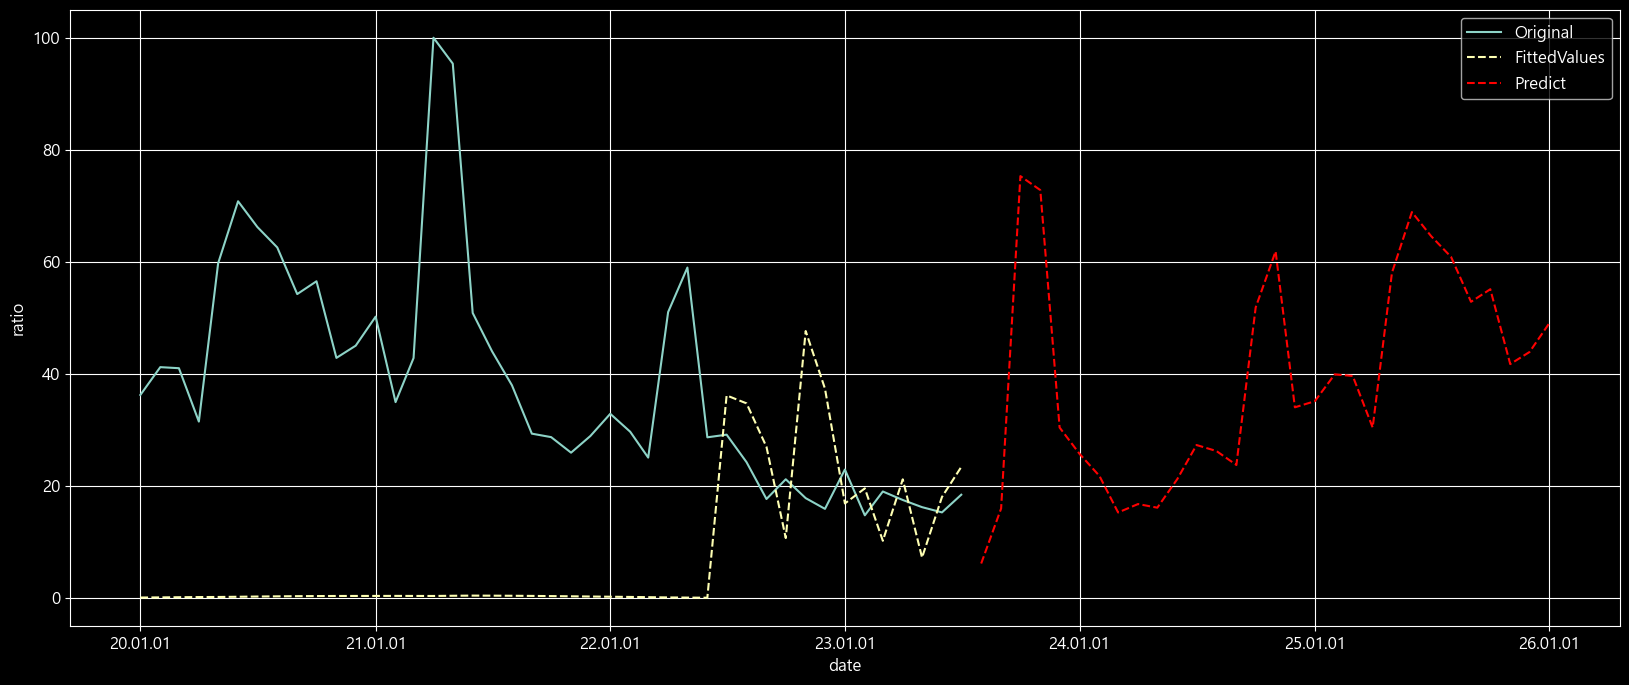

In [157]:
# 시각화# 
plt.figure(figsize=(20,8))

sb.lineplot(data=df2, x=df2.index, y='ratio', label='Original')
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('date')
plt.ylabel('ratio')
plt.legend()

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()